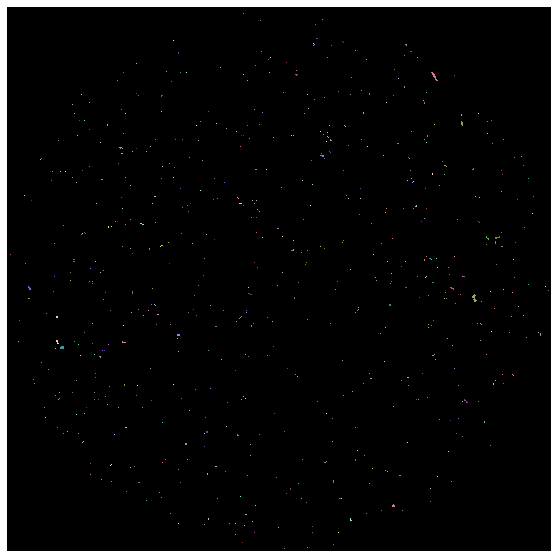

In [1]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.io import fits
from photutils import detect_threshold,detect_sources
import os
import csv
import numpy as np
import plotly
from io import StringIO

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

import matplotlib.pyplot as plt
import pandas as pd
import requests

DR2_path = "../../../../data/mostertrij/data/LoTSS_DR2"

mosaic_path = "../../../../data/mostertrij/data/LoTSS_DR2_mosaic/"

listOfFiles = []
for (directory_path, directory_names, filenames) in os.walk(DR2_path):
    listOfFiles += [os.path.join(directory_path, file) for file in filenames if file.endswith('mosaic-blanked'+'.' + 'fits')]
    
listOfFiles
data = fits.open(listOfFiles[2])[0].data
sigma_1, sigma_2 = 8,9
# gsimga defines a Gaussuan kernel, which is used to smooth(convolve) the noise
# this parameter has the smallest influence
for gsigma in range(sigma_1,sigma_2):
    #nsigma defines threshold, larger the value higher the threshold
    for nsigma in range(sigma_1,sigma_2):
        # npixels defines the number of pixels a source at least contains
        for npixels in range(12,13):

            threshold = detect_threshold(data, nsigma=nsigma)

            # define a Gaussian kernal
            sigma = gsigma * gaussian_fwhm_to_sigma  # FWHM = 3.
            kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
            kernel.normalize()

            sources = detect_sources(data, threshold, npixels=npixels, filter_kernel=kernel)

            # plot
            fig, ax1 = plt.subplots(1, 1, figsize=(10,10), frameon=False)
            ax1.set_axis_off()
            cmap = sources.make_cmap(random_state=12345)
            plt.imshow(sources, origin='lower', cmap=cmap)
            #plt.savefig('./../n%s_g%s_np%s.png'%(nsigma, gsigma, npixels), dpi=96 * 10, bbox_inches='tight', pad_inches=0)

## Deblending 

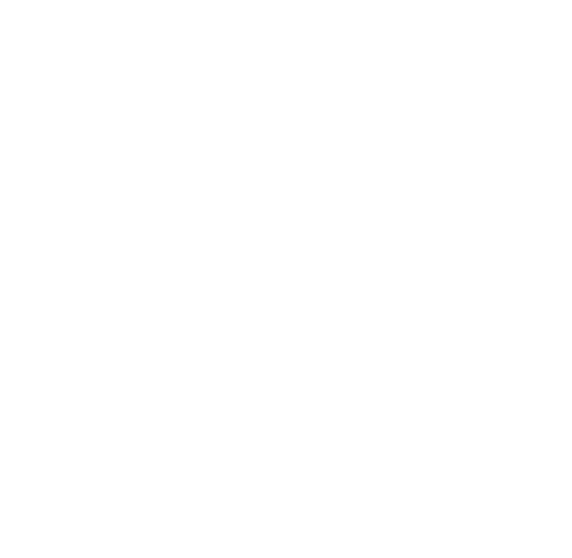

In [2]:
## Calling the deblend_sources method. The npixels and nlevels should be optimised, and also the contrast.
## The kernel should be the same
## kernel with which the detect_sources method was called. 

from photutils import deblend_sources
segm_deblend = deblend_sources(data, sources, npixels=12,
                               filter_kernel=kernel, nlevels=32, # kernel should be same as that of thresholding
                               contrast=0.001)  
fig, ax1 = plt.subplots(1,figsize=(10,10), frameon=False)
ax1.set_axis_off()
cmapdbS = segm_deblend.make_cmap(random_state=12345)
#plt.imshow(segm_deblend, origin='lower', cmap=cmapdbS)

In [3]:
segm_deblend.nlabels, sources.nlabels

(2730, 2557)

Check the max_label or nlabels to see if there has been any deblending. We see a difference in the two (the deblended vs the original) which implies some deblending has been done. Changing the parameters we can see how much the changes affect the debledning process.

## Validating Deblending 

This part is only used for visualization and optimization

In [4]:
from photutils import source_properties
cat_sources = source_properties(data, sources)  ## properties of the sources object
cat_segmented = source_properties(data, segm_deblend) ## properties of the deblended sources object
cat_segmented.to_table()[1:5]  ## visuaization of what properties of available for each source object

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,4408.917675727913,30.545078074596198,None,None,0.22731149155721614,None,None,None,None,4403.0,4414.0,26.0,35.0,0.0004933708918466827,0.006544063946452236,4406.0,35.0,4410.0,31.0,103.0,5.725898905580716,34.72792206135786,2.4899520910717685,1.9848800606764665,19.19005830952315,0.6037734942161,0.20284407567773732,1.2544597229835481,5.955666387255866,0.7016245714992644,4.18394388384782,0.17129131013118146,-0.05744923708766891,0.24382590362065265,0.4055944772301786
3,4295.467718521832,38.00335672747196,None,None,0.023406865439554198,None,None,None,None,4293.0,4298.0,36.0,40.0,0.0005434765746494594,0.0014670435011006817,4297.0,36.0,4295.0,38.0,26.0,2.876813695875796,15.65685424949238,1.3990643980181834,1.1988332823627819,3.252058638206213,0.5155123801462284,0.1431178692982502,1.1670216523024501,1.955707177459129,0.029461590944640154,1.4388752512435745,0.5114817581882607,-0.020945618909442184,0.6952017172883203,0.18212271923524687
4,4559.856312844945,39.835698955127064,None,None,0.02062019197605635,None,None,None,None,4558.0,4562.0,38.0,42.0,0.0005612057064190202,0.0014441355905485825,4561.0,42.0,4560.0,40.0,22.0,2.6462837142006137,14.242640687119284,1.238968098846012,1.1705044241603455,40.92675122793029,0.3278166195880439,0.055258625907667946,1.0584907440523161,1.4642491710535424,0.08164835782973813,1.440873385883501,0.6851086519971403,-0.07764456879910032,0.6962234056070847,0.1707015189699198
5,3722.2834462051965,48.682435133513735,None,None,0.027893661350931645,None,None,None,None,3720.0,3725.0,45.0,52.0,0.0005521510645464004,0.0011562360267899623,3721.0,51.0,3722.0,49.0,34.0,3.2897623212397704,19.899494936611664,1.9179687879380871,1.2342923668034083,57.827980063942555,0.7654112844546828,0.3564585750478585,1.553901522461227,2.134492302701547,0.9713264350208017,3.067589615552307,0.5473663582952655,-0.3466379014700986,0.3808688335022496,0.13069341914791754


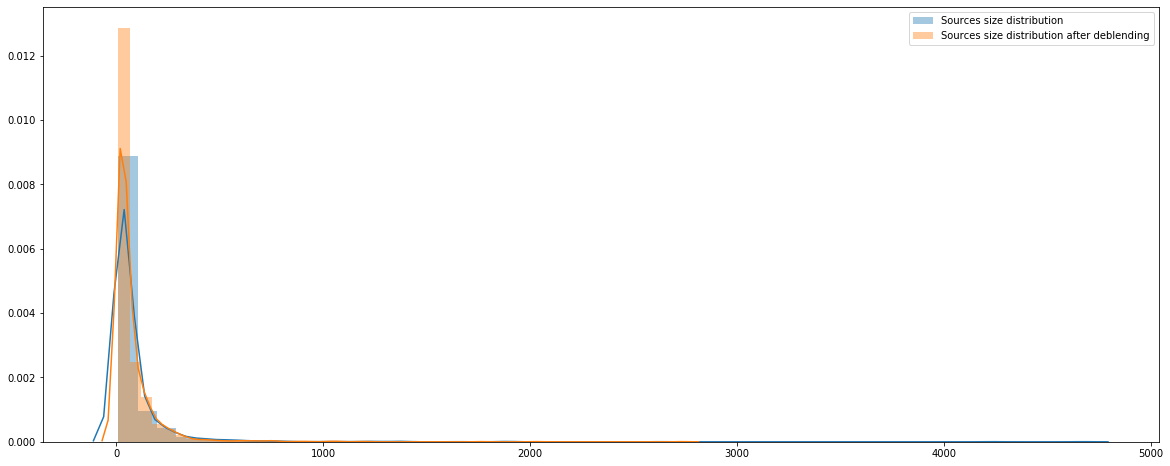

In [5]:
import seaborn as sns
catList_sources = list(cat_sources.area)
catList_segmented =list(cat_segmented.area)
Areas_sources =[]
Areas_segmented = []
for i in catList_sources:
    Areas_sources.append(float(str(i)[:-5]))
for i in catList_segmented:
    Areas_segmented.append(float(str(i)[:-5]))
    
## Visualization of the distribution of the source sizes for the un-deblended and deblended sources.
    
f, ax = plt.subplots(figsize=(20, 8))
sns.distplot(Areas_sources, label="Sources size distribution")
sns.distplot(Areas_segmented, label = "Sources size distribution after deblending")
plt.legend()
#ax.set_yscale('log')


In [6]:
def visualize_deblending(label, data,sources, deblended):
    x_min = int(str(cat_sources[val].bbox_xmin)[:-6])
    x_max = int(str(cat_sources[val].bbox_xmax)[:-6])
    y_min = int(str(cat_sources[val].bbox_ymin)[:-6])
    y_max = int(str(cat_sources[val].bbox_ymax)[:-6])

    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize = (6,6), frameon=False)

    ax1.imshow(data[y_min:y_max,x_min:x_max], origin='lower', cmap ='Greys_r')
    ax2.imshow(sources, origin='lower', cmap=cmapdbS)
    ax2.set_xlim([x_min,x_max])
    ax2.set_ylim([y_min,y_max])
    ax3.imshow(segm_deblend, origin='lower', cmap=cmapdbS)
    ax3.set_xlim([x_min,x_max])
    ax3.set_ylim([y_min,y_max])

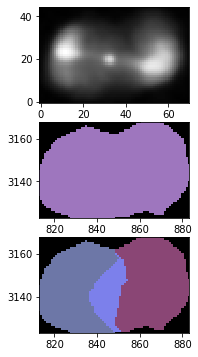

In [7]:
## Lets visualize a source object with original area >2500.
for i in range(len(Areas_sources)):
    if Areas_sources[i]>2500:
        val=i
        break

visualize_deblending(val,data,sources, segm_deblend)